In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
np.core.arrayprint._line_width = 160

### Utilities for working with block matricies 

#### hstack, vstack with None support

In [2]:
def vStackOrNone(top, bottom):
    if top is not None:
        return np.vstack([top, bottom])
    return bottom

In [3]:
def hStackOrNone(left, right):
    if left is not None:
        return np.hstack([left, right])
    return right

In [4]:
m2by3a = np.arange(0, 6).reshape((2, 3))
m2by3b = np.arange(6, 12).reshape((2, 3))

In [5]:
vStackOrNone(m2by3a, m2by3b)

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [6]:
hStackOrNone(m2by3a, m2by3b)

array([[ 0,  1,  2,  6,  7,  8],
       [ 3,  4,  5,  9, 10, 11]])

#### Transform matrix: reshape rows into blocks, and tile with the blocks.

In [7]:
def blockToRow(array, up:int, left:int, height:int, width:int):
    return array[up:(up + height), left:(left + width)].reshape((1, height * width))

In [8]:
m4by6 = np.arange(24).reshape((4, 6))
m4by6

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23]])

In [9]:
blockToRow(m4by6, up=1, left=2, height=2, width=2)

array([[ 8,  9, 14, 15]])

In [10]:
def blockTile(array, height:int, width:int):
    stack = None
    for i in range(0, array.shape[0], height):
        for j in range(0, array.shape[1], width):
            stack = vStackOrNone(stack, blockToRow(array, up=i, left=j, height=height, width=width))
    return stack

In [11]:
tiled = blockTile(m4by6, height=2, width=3)
tiled

array([[ 0,  1,  2,  6,  7,  8],
       [ 3,  4,  5,  9, 10, 11],
       [12, 13, 14, 18, 19, 20],
       [15, 16, 17, 21, 22, 23]])

#### blockUnTile, for restoring the block-to-row matrix to the original config 

In [12]:
def blockUnTile(array, blkH:int, blkW:int, blkPerRow:int):
    mRet = None
    for i in range(0, array.shape[0], blkPerRow):
        hStack = None
        for j in range(blkPerRow):
            hStack = hStackOrNone(hStack, array[i+j, :].reshape(blkH, blkW))
        mRet = vStackOrNone(mRet, hStack)
    return mRet

In [13]:
unBlocked = blockUnTile(array=tiled, blkH=2, blkW=3, blkPerRow=2)
np.array_equal(m4by6, unBlocked)

True

### SVD for line segment vectors

In [14]:
from scipy import misc
f = misc.face()

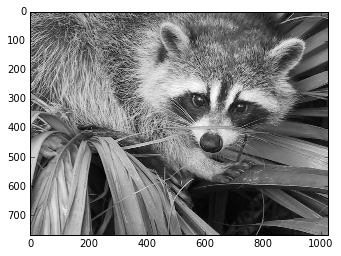

In [15]:
from PIL import Image
img = Image.fromarray(f, 'RGB')
a = img.convert('L')
imgmat = np.matrix(a)
plt.imshow(imgmat, cmap='gray')
plt.show()

In [16]:
U_l, sigma_l, V_l = np.linalg.svd(imgmat)

In [17]:
U_l.shape, sigma_l.shape, V_l.shape

((768, 768), (768,), (1024, 1024))

#### Heatmap of U

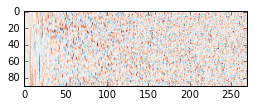

In [18]:
plt.figure(figsize=(4, 12))
plt.imshow(U_l[:90, :270], cmap='RdBu')
plt.show()

### Histogram of sigma

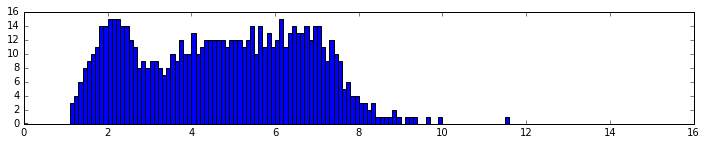

In [19]:
bins = np.arange(0, 15, 0.1)
plt.figure(figsize=(12, 2))
plt.hist(np.log(sigma_l), bins=bins)
plt.show()

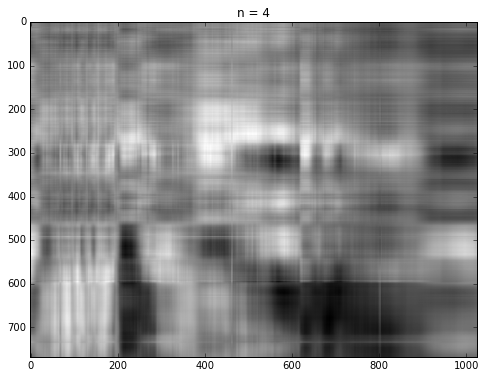

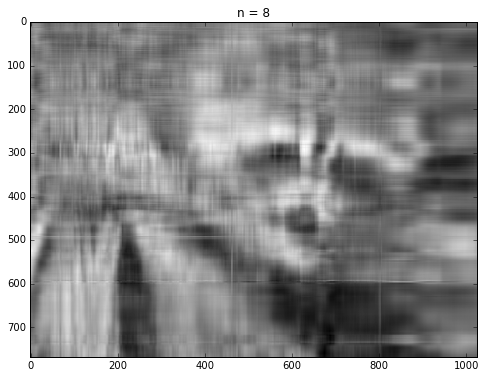

In [20]:
for i in range(4, 9, 4):
    reconstimg = np.matrix(U_l[:, :i]) * np.diag(sigma_l[:i]) * np.matrix(V_l[:i, :])
    plt.figure(figsize=(8, 8))
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

### SVD for vectors from image blocks, blocksize: 16 x 16

In [21]:
blk_16 = blockTile(imgmat, 16, 16)

In [22]:
blk_16.shape

(3072, 256)

In [23]:
U_b16, sigma_b16, V_b16 = np.linalg.svd(blk_16)

In [24]:
U_b16.shape, sigma_b16.shape, V_b16.shape

((3072, 3072), (256,), (256, 256))

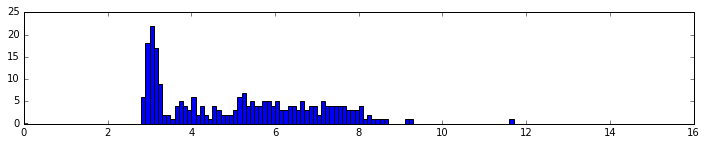

In [25]:
bins = np.arange(0, 15, 0.1)
plt.figure(figsize=(12, 2))
plt.hist(np.log(sigma_b16), bins=bins)
plt.show()

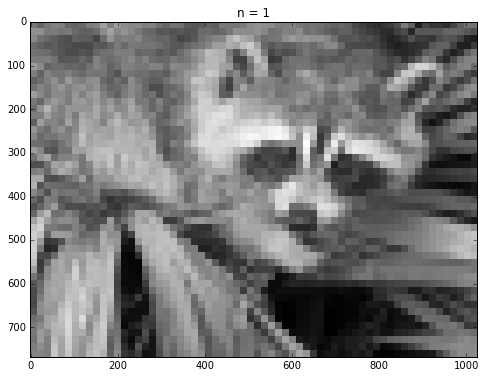

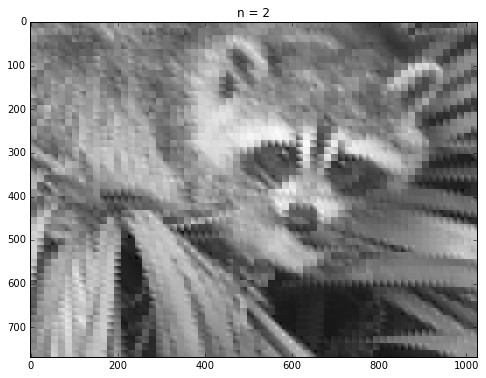

In [27]:
for i in range(1, 3, 1):
    reconstimg = np.matrix(U_b16[:, :i]) * np.diag(sigma_b16[:i]) * np.matrix(V_b16[:i, :])
    plt.figure(figsize=(8, 8))
    plt.imshow(blockUnTile(reconstimg, 16, 16, 64), cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

### SVD for vectors from image blocks, blocksize: 32 x 32

In [28]:
blk_32 = blockTile(imgmat, 32, 32)

In [29]:
blk_32.shape

(768, 1024)

In [30]:
U_b32, sigma_b32, V_b32 = np.linalg.svd(blk_32)

In [31]:
U_b32.shape, sigma_b32.shape, V_b32.shape

((768, 768), (768,), (1024, 1024))

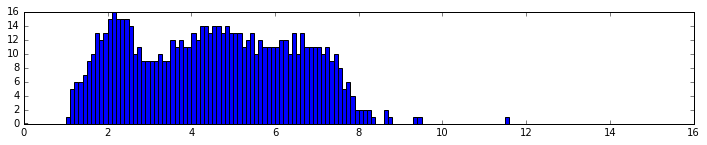

In [32]:
bins = np.arange(0, 15, 0.1)
plt.figure(figsize=(12, 2))
plt.hist(np.log(sigma_b32), bins=bins)
plt.show()

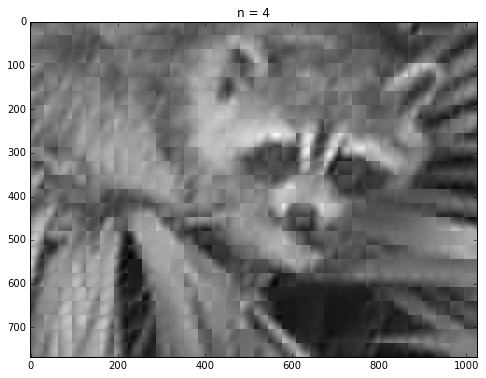

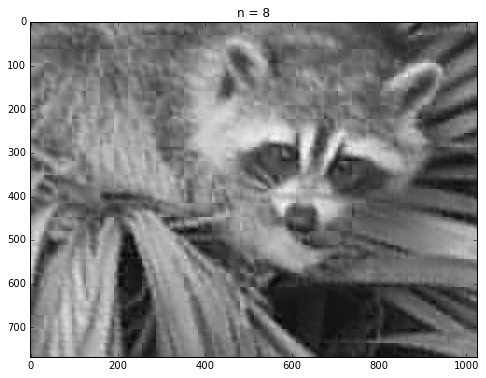

In [33]:
for i in range(4, 9, 4):
    reconstimg = np.matrix(U_b32[:, :i]) * np.diag(sigma_b32[:i]) * np.matrix(V_b32[:i, :])
    plt.figure(figsize=(8, 8))
    plt.imshow(blockUnTile(reconstimg, 32, 32, 32), cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

### SVD for vectors from image blocks, blocksize: 64 x 64

In [ ]:
blk_64 = blockTile(imgmat, 64, 64)

In [ ]:
blk_64.shape

In [ ]:
U_b64, sigma_b64, V_b64 = np.linalg.svd(blk_64)

In [ ]:
bins = np.arange(0, 15, 0.1)
plt.figure(figsize=(12, 2))
plt.hist(np.log(sigma_b64), bins=bins)
plt.show()

In [ ]:
U_b64.shape, sigma_b64.shape, V_b64.shape

In [ ]:
for i in range(16, 33, 16):
    reconstimg = np.matrix(U_b64[:, :i]) * np.diag(sigma_b64[:i]) * np.matrix(V_b64[:i, :])
    plt.figure(figsize=(8, 8))
    plt.imshow(blockUnTile(reconstimg, 64, 64, 16), cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

In [ ]:
plt.plot(np.cumsum(sigma_l) / np.sum(sigma_l))
plt.plot(np.cumsum(sigma_b16) / np.sum(sigma_b16))
plt.plot(np.cumsum(sigma_b32) / np.sum(sigma_b32))
plt.plot(np.cumsum(sigma_b64) / np.sum(sigma_b64))
plt.legend(['sigma_l', 'sigma_b16', 'sigma_b32', 'sigma_b64'], loc='lower right')
plt.show()